In [117]:
!pip install yfinance plotly pgmpy

# Library

In [118]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx

# Fitur 1 – Manajemen Portofolio

## Portofolio & Industri

AAPL -> Apple Inc

GOOGL -> Alphabet Inc

MSFT -> Microsoft

TSLA -> Tesla

JPM -> JPMorgan Chase

XOM -> Exxon Mobil

MFC -> Manulife Financial Corp

In [119]:
portfolio = {
    'AAPL': (10, 'Technology'),
    'GOOGL': (5, 'Technology'),
    'MSFT': (8, 'Technology'),
    'TSLA': (4, 'Automotive'),
    'JPM': (6, 'Financial'),
    'XOM': (7, 'Energy'),
    'MFC': (3, 'Financial')
}

symbols = list(portfolio.keys())
period='1y'

data = yf.download(symbols, period=period)['Adj Close']
data.dropna(axis=1, inplace=True)
data

[*********************100%***********************]  7 of 7 completed


Ticker,AAPL,GOOGL,JPM,MFC,MSFT,TSLA,XOM
Date,,,,,,,
2023-12-07,193.322906,136.591782,153.133270,19.407995,368.196686,242.639999,95.173500
2023-12-08,194.755875,134.656570,154.822922,19.495993,371.452301,243.839996,96.266228
2023-12-11,192.238220,132.960754,155.389404,20.131516,368.544067,239.740005,96.333916
2023-12-12,193.760773,132.192673,156.776291,20.444391,371.601166,237.009995,94.815704
2023-12-13,196.994919,132.242554,157.303680,20.551943,371.591278,239.289993,95.656998
...,...,...,...,...,...,...,...
2024-12-02,239.589996,171.490005,246.250000,32.320000,430.980011,357.089996,117.849998
2024-12-03,242.649994,171.339996,244.820007,32.070000,431.200012,351.420013,117.669998
2024-12-04,243.009995,174.369995,243.399994,32.290001,437.420013,357.929993,114.279999


## Nilai Portofolio

In [120]:
latest_prices = data.iloc[-1]
portfolio_value = 0
portfolio_details = []
for symbol, values in portfolio.items():
    shares = values[0]
    stock_industry = values[1]
    if symbol in latest_prices.index:
        price = latest_prices[symbol]
        total_val = price * shares
        portfolio_value += total_val
        portfolio_details.append({
            'Symbol': symbol,
            'Industry': stock_industry,
            'Shares': shares,
            'Price': price,
            'Total Value': total_val
        })

portfolio_df = pd.DataFrame(portfolio_details)
portfolio_df

,Symbol,Industry,Shares,Price,Total Value
0,AAPL,Technology,10,242.839996,2428.399963
1,GOOGL,Technology,5,174.710007,873.550034
2,MSFT,Technology,8,443.570007,3548.560059
3,TSLA,Automotive,4,389.220001,1556.880005
4,JPM,Financial,6,247.360001,1484.160004
5,XOM,Energy,7,113.570000,794.989998
6,MFC,Financial,3,32.400002,97.200005


## Visualisasi Komposisi Portofolio

In [121]:
fig = px.pie(portfolio_df, names='Symbol', values='Total Value', title='Portfolio Composition by Value')
fig.show()

fig = px.bar(portfolio_df, x='Symbol', y='Total Value', color='Industry', title='Portfolio by Industry')
fig.show()

# Fitur 2 – Analisis Risiko

## Bayesian Network (BN)

### Data training untuk BN

In [122]:
window = 20
vol_threshold = 0.015
ret_threshold = 0

data = data.dropna()
returns_data = data.pct_change().dropna()

rolling_std = returns_data.rolling(window).std().mean(axis=1)
rolling_mean = returns_data.rolling(window).mean().mean(axis=1)

df_states = pd.DataFrame({
    'MarketVolatility': np.where(rolling_std < vol_threshold, 'Low', 'High'),
    'CompanyPerformance': np.where(rolling_mean > ret_threshold, 'Good', 'Poor')
}).dropna()

conditions = [
    (df_states['MarketVolatility']=='Low') & (df_states['CompanyPerformance']=='Good'),
    (df_states['MarketVolatility']=='High') & (df_states['CompanyPerformance']=='Poor')
]
choices = ['Low','High']
df_states['StockRisk'] = np.select(conditions, choices, default='Medium')
df_states.dropna(inplace=True)
df_states = df_states.astype(str)

### Membangun BN dan learning CPD

In [123]:
model = BayesianNetwork([
    ('MarketVolatility', 'StockRisk'),
    ('CompanyPerformance', 'StockRisk')
])
model.fit(df_states, estimator=MaximumLikelihoodEstimator)

infer = VariableElimination(model)

def get_risk_category(prob_dist):
    max_idx = np.argmax(prob_dist.values)
    return prob_dist.state_names['StockRisk'][max_idx]

mv_cpd = model.get_cpds('MarketVolatility')
cp_cpd = model.get_cpds('CompanyPerformance')

known_mv_states = mv_cpd.state_names['MarketVolatility']
known_cp_states = cp_cpd.state_names['CompanyPerformance']

def fallback_state(var_name, desired_state, known_states):
    if desired_state in known_states:
        return desired_state
    else:
        warnings.warn(f"State '{desired_state}' tidak ditemukan untuk {var_name}. Menggunakan fallback.")

        if len(known_states) > 0:
            for s in known_states:
                if s != desired_state:
                    return s

            warnings.warn(f"Tidak ada fallback state untuk {var_name}.")
            return None
        else:
            warnings.warn(f"Tidak ada state sama sekali untuk {var_name}.")
            return None

def evaluate_stock_risk(stock_symbol):
    rets = data[stock_symbol].pct_change().dropna()
    stock_std = rets.rolling(window).std()
    stock_mean = rets.rolling(window).mean()

    result = []
    for date in stock_std.dropna().index:
        vol_val = stock_std.loc[date]
        ret_val = stock_mean.loc[date]

        mv = 'Low' if vol_val < vol_threshold else 'High'
        cp = 'Good' if ret_val > ret_threshold else 'Poor'

        mv = fallback_state('MarketVolatility', mv, known_mv_states)
        cp = fallback_state('CompanyPerformance', cp, known_cp_states)

        if mv is None or cp is None:
            warnings.warn(f"Melewati inferensi untuk {stock_symbol} pada {date} karena state tidak tersedia.")
            continue

        prob_dist = infer.query(['StockRisk'], evidence={'MarketVolatility': mv, 'CompanyPerformance': cp})
        risk_cat = get_risk_category(prob_dist)
        result.append((date, risk_cat))

    risk_df = pd.DataFrame(result, columns=['Date','StockRisk'])
    risk_df['Symbol'] = stock_symbol
    return risk_df

all_risk = []
for sym in symbols:
    rdf = evaluate_stock_risk(sym)
    if not rdf.empty:
        all_risk.append(rdf)

## Visualisasi Directed Acylic Graph (DAG)

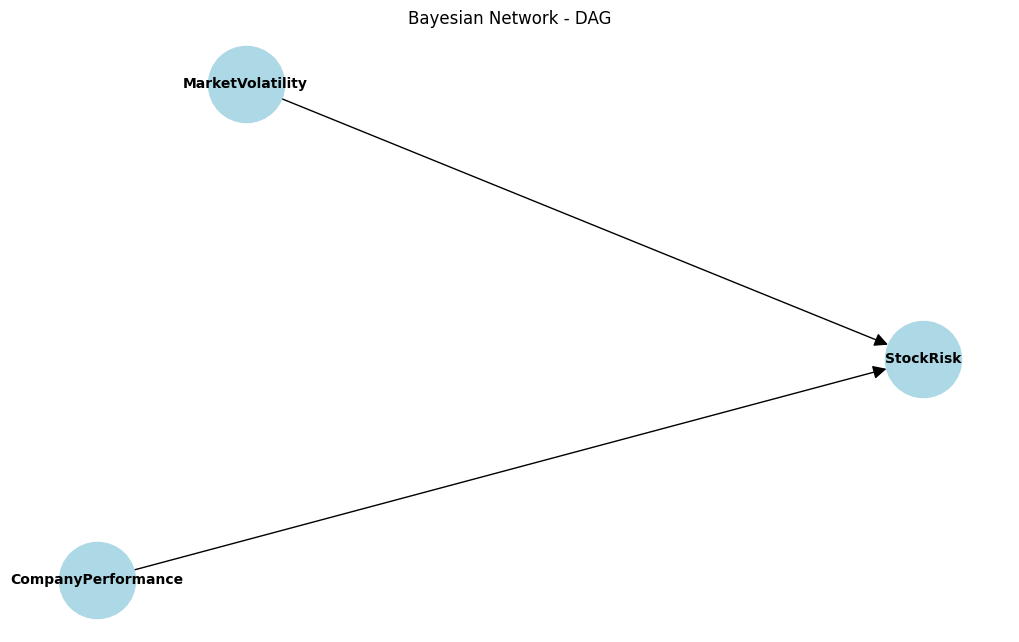

In [124]:
G = nx.DiGraph(model.edges())
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Bayesian Network - DAG")
plt.show()

## Conditional Probability Distribution (CPD)

In [125]:
for cpd in model.get_cpds():
    print(f"\nCPD untuk {cpd.variable}:")
    print(cpd)


CPD untuk MarketVolatility:
+------------------------+----------+
| MarketVolatility(High) | 0.737052 |
+------------------------+----------+
| MarketVolatility(Low)  | 0.262948 |
+------------------------+----------+

CPD untuk StockRisk:
+--------------------+-----+--------------------------+
| CompanyPerformance | ... | CompanyPerformance(Poor) |
+--------------------+-----+--------------------------+
| MarketVolatility   | ... | MarketVolatility(Low)    |
+--------------------+-----+--------------------------+
| StockRisk(High)    | ... | 0.0                      |
+--------------------+-----+--------------------------+
| StockRisk(Low)     | ... | 0.0                      |
+--------------------+-----+--------------------------+
| StockRisk(Medium)  | ... | 1.0                      |
+--------------------+-----+--------------------------+

CPD untuk CompanyPerformance:
+--------------------------+----------+
| CompanyPerformance(Good) | 0.733068 |
+--------------------------+----

## Visualisasi Tingkat Risiko

In [126]:
if len(all_risk) == 0:
    print("Tidak ada data risiko yang tersedia setelah fallback.")
else:
    all_risk_df = pd.concat(all_risk).reset_index(drop=True)

    mapping = {'Low':1, 'Medium':2, 'High':3}
    all_risk_df['RiskLevel'] = all_risk_df['StockRisk'].map(mapping)


    fig = px.line(all_risk_df, x='Date', y='RiskLevel', color='Symbol',
                  title='Perkembangan Risiko Saham selama 1 Tahun Terakhir (Dengan Fallback State)',
                  labels={'RiskLevel':'Risk Level (1=Low,2=Medium,3=High)'})
    fig.show()

    avg_risk = all_risk_df.groupby('Symbol')['RiskLevel'].mean().reset_index()

    fig2 = px.bar(avg_risk, x='Symbol', y='RiskLevel',
                  title='Rata-rata Risk Level Saham selama 1 Tahun Terakhir (Dengan Fallback State)',
                  labels={'RiskLevel':'Average Risk Level (1=Low,2=Medium,3=High)'})
    fig2.show()

# Fitur 3 – Optimasi Portofolio

## Grey Wolf Optimization (GWO)

In [127]:
mean_returns = returns_data.mean()
cov_matrix = returns_data.cov()

def portfolio_performance(weights, mean_returns, cov_matrix, rf=0.01):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - rf)/vol if vol != 0 else 0
    return ret, vol, sharpe

def objective_function(weights, mean_returns, cov_matrix, investor_type='auto', rf=0.01):
    ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix, rf)
    if investor_type == 'auto':
        investor_type = 'moderate'
    if investor_type == 'conservative':
        return vol
    elif investor_type == 'moderate':
        return -sharpe
    elif investor_type == 'aggressive':
        return -ret
    else:
        return -sharpe

def GWO_optimize(mean_returns, cov_matrix, investor_type='auto', n_agents=2*len(symbols), max_iter=3*len(symbols)):
    dim = len(mean_returns)
    lb = np.zeros(dim)
    ub = np.ones(dim)
    def check_bounds(x):
        x = np.maximum(x, lb)
        x = np.minimum(x, ub)
        x /= np.sum(x)
        return x

    positions = np.random.dirichlet(np.ones(dim), size=n_agents)

    Alpha_pos = np.zeros(dim)
    Alpha_score = float('inf')
    Beta_pos = np.zeros(dim)
    Beta_score = float('inf')
    Delta_pos = np.zeros(dim)
    Delta_score = float('inf')

    for l in range(max_iter):
        for i in range(n_agents):
            positions[i] = check_bounds(positions[i])
            fitness = objective_function(positions[i], mean_returns, cov_matrix, investor_type)
            if fitness < Alpha_score:
                Alpha_score, Alpha_pos = fitness, positions[i].copy()
            elif fitness < Beta_score:
                Beta_score, Beta_pos = fitness, positions[i].copy()
            elif fitness < Delta_score:
                Delta_score = fitness
                Delta_pos = positions[i].copy()

        a = 2 - l*(2/max_iter)
        for i in range(n_agents):
            for j in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A1 = 2*a*r1 - a
                C1 = 2*r2
                D_alpha = abs(C1*Alpha_pos[j] - positions[i][j])
                X1 = Alpha_pos[j] - A1*D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2 = 2*a*r1 - a
                C2 = 2*r2
                D_beta = abs(C2*Beta_pos[j] - positions[i][j])
                X2 = Beta_pos[j] - A2*D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3 = 2*a*r1 - a
                C3 = 2*r2
                D_delta = abs(C3*Delta_pos[j] - positions[i][j])
                X3 = Delta_pos[j] - A3*D_delta

                positions[i][j] = (X1+X2+X3)/3

    return check_bounds(Alpha_pos)

## Bobot Awal Portofolio

In [128]:
latest_prices = data.iloc[-1]
total_value = 0
portfolio_data = []
for sym, values in portfolio.items():
    shares = values[0]
    if sym in latest_prices.index:
        val = latest_prices[sym]*shares
        total_value += val
        portfolio_data.append([sym, shares, latest_prices[sym], val])

portfolio_df = pd.DataFrame(portfolio_data, columns=['Symbol','Shares','Price','TotalValue'])
initial_weights = portfolio_df['TotalValue']/portfolio_df['TotalValue'].sum()

initial_ret, initial_vol, initial_sharpe = portfolio_performance(initial_weights.values, mean_returns, cov_matrix)

## Portofolio Awal vs Portofolio Sesudah Dioptimasi

In [129]:
investor_type = 'moderate'
optimal_weights_gwo = GWO_optimize(mean_returns, cov_matrix, investor_type)
optimal_ret_gwo, optimal_vol_gwo, optimal_sharpe_gwo = portfolio_performance(optimal_weights_gwo, mean_returns, cov_matrix)

comparison_data = {
    'Symbol': data.columns,
    'Initial Weight': initial_weights.values,
    'Optimized Weight (GWO)': optimal_weights_gwo
}
comparison_df = pd.DataFrame(comparison_data)

summary_df = pd.DataFrame({
    'Symbol': ['Portfolio Return','Portfolio Risk','Sharpe Ratio'],
    'Initial Weight': [f"{initial_ret*100:.2f}%", f"{initial_vol*100:.2f}%", f"{initial_sharpe:.2f}"],
    'Optimized Weight (GWO)': [f"{optimal_ret_gwo*100:.2f}%", f"{optimal_vol_gwo*100:.2f}%", f"{optimal_sharpe_gwo:.2f}"]
})

final_table = pd.concat([comparison_df, summary_df], ignore_index=True)
final_table

,Symbol,Initial Weight,Optimized Weight (GWO)
0,AAPL,0.225191,0.01288
1,GOOGL,0.081006,0.002212
2,JPM,0.329066,0.009294
3,MFC,0.144373,0.000821
4,MSFT,0.137629,0.00144
5,TSLA,0.073721,0.96381
6,XOM,0.009014,0.009542
7,Portfolio Return,0.16%,0.26%
8,Portfolio Risk,0.98%,3.76%
9,Sharpe Ratio,-0.86,-0.20


## Visualisasi Komposisi Portofolio Yang Sudah Dioptimasi

In [130]:
stocks_only = final_table[final_table['Symbol'].isin(data.columns)]

fig = px.pie(stocks_only, names='Symbol', values='Optimized Weight (GWO)',
             title='Optimized Portfolio Composition (GWO)')
fig.show()

## Visualisasi Perbandingan dengan Uniform Efficient Frontier (UEF)

In [131]:
n_random = 1000
random_weights = np.random.dirichlet(np.ones(len(mean_returns)), n_random)
random_results = []
for w in random_weights:
    r, v, s = portfolio_performance(w, mean_returns, cov_matrix)
    random_results.append((r,v,s))
random_df = pd.DataFrame(random_results, columns=['Return','Vol','Sharpe'])

fig = px.scatter(random_df, x='Vol', y='Return', title='GWO vs UEF Efficient Frontier',
                 labels={'Vol':'Risk (Volatility)','Return':'Mean Return'})
fig.add_scatter(x=[optimal_vol_gwo], y=[optimal_ret_gwo], mode='markers',
                marker=dict(color='red', size=10), name='GWO Optimal')
fig.show()